# Importing Libraries

In [1]:
# necessary imports 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import time
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score, ShuffleSplit, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, auc, accuracy_score, roc_curve, roc_auc_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier

from imblearn.combine import SMOTEENN
from sklearn.metrics import DistanceMetric
from collections import Counter

import torch
import torch.nn as nn
from torch import optim
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F

from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
import skorch
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring, EarlyStopping, Checkpoint

plt.style.use('fivethirtyeight')
%matplotlib inline

# Data Loading and Cleaning

In [2]:
df = pd.read_csv('Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [4]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [5]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


# Exploratory Data Analysis

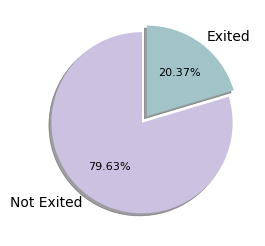

In [6]:

#Exploratory Data Analysis
values = df.Exited.value_counts()
labels = ['Not Exited', 'Exited']

fig, ax = plt.subplots(figsize = (4, 3), dpi = 100)
explode = (0, 0.09)

colors = ['#cbc1e1','#a2c4c9']
patches, texts, autotexts = ax.pie(values, labels = labels, autopct = '%1.2f%%', shadow = True,
                                   startangle = 90, explode = explode,colors=colors)

plt.setp(texts, color = 'black')
plt.setp(autotexts, size = 8, color = 'black')
autotexts[1].set_color('black')
plt.show()

There is clearly a Class Imbalance.

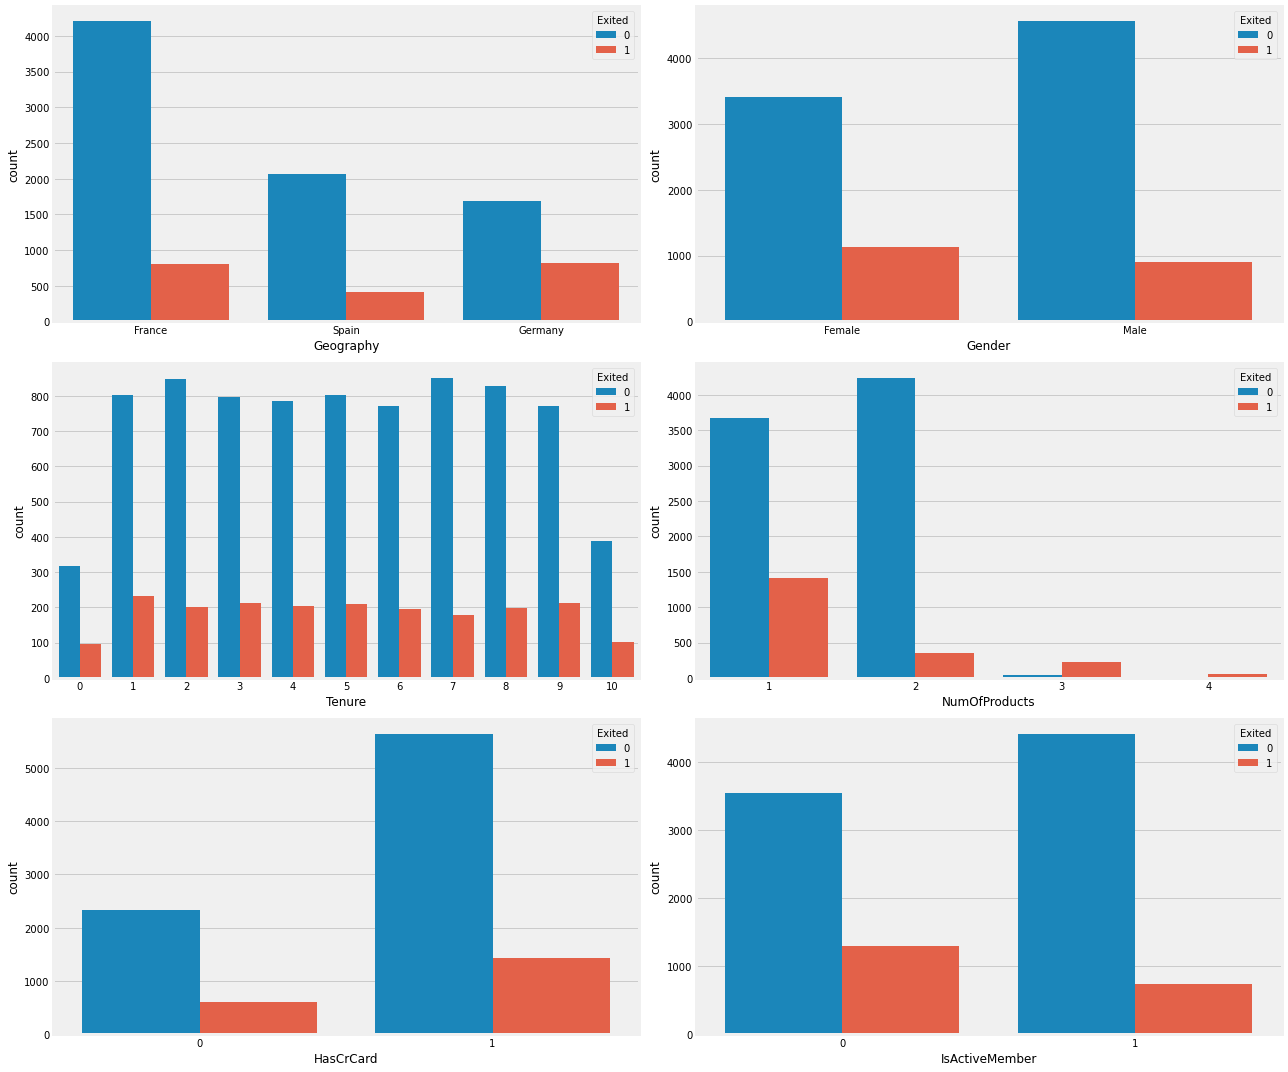

In [7]:
fig, ax = plt.subplots(3, 2, figsize = (18, 15))

sns.countplot('Geography', hue = 'Exited', data = df, ax = ax[0][0])
sns.countplot('Gender', hue = 'Exited', data = df, ax = ax[0][1])
sns.countplot('Tenure', hue = 'Exited', data = df, ax = ax[1][0])
sns.countplot('NumOfProducts', hue = 'Exited', data = df, ax = ax[1][1])
sns.countplot('HasCrCard', hue = 'Exited', data = df, ax = ax[2][0])
sns.countplot('IsActiveMember', hue = 'Exited', data = df, ax = ax[2][1])

plt.tight_layout()
plt.show()

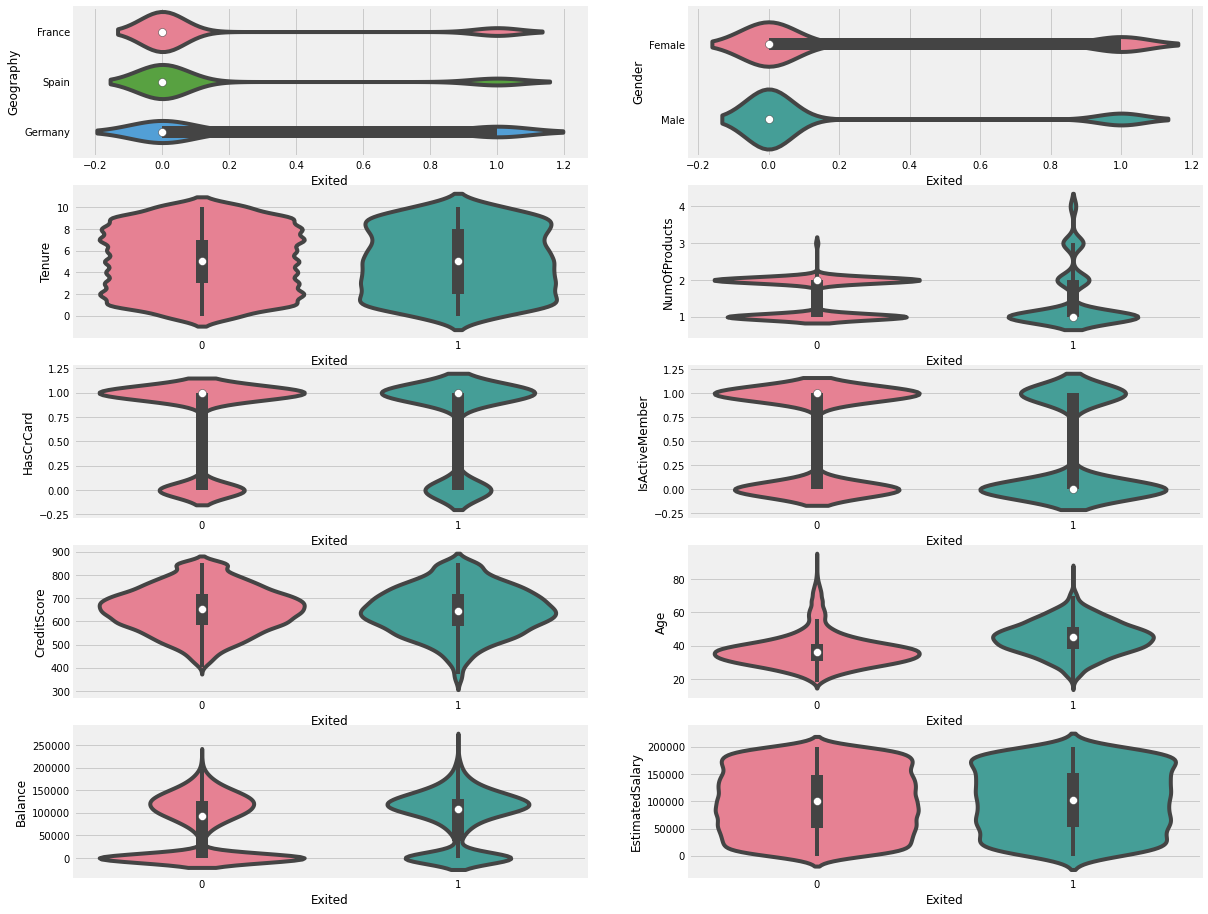

In [8]:
#plotting churn rate 
plt.figure(figsize=(18, 16))

for e, column in enumerate(['Geography','Gender','Tenure',
                            'NumOfProducts','HasCrCard','IsActiveMember','CreditScore','Age','Balance','EstimatedSalary'
                            ]):
    plt.subplot(5, 2, e + 1)
    sns.violinplot( data=df, x='Exited', y=column, palette="husl")

In [9]:
df.Geography.unique()

array(['France', 'Spain', 'Germany'], dtype=object)

From above Plots we can conclude that:-
- Majority of the customers are from france but most customers which churned are from germany maybe because of lack of resources as there are not many customers.
- The proportion of female customers churning is also greater than that of male customers.
- Majority of customers have tenure between 1 to 9 and churing rate is also high between these tenures.
- Most of the customers have 1 or 2 products and most customers which churned are having 1 products maybe they are not satisfied so they are churning.
- Interestingly, majority of customers that churned are those with credit cards but this can be a coincidence as majority of customers have credit cards.
- Unsurprisingly the inactive members have a greater churn and the overall proportion of inactive members is also very high.

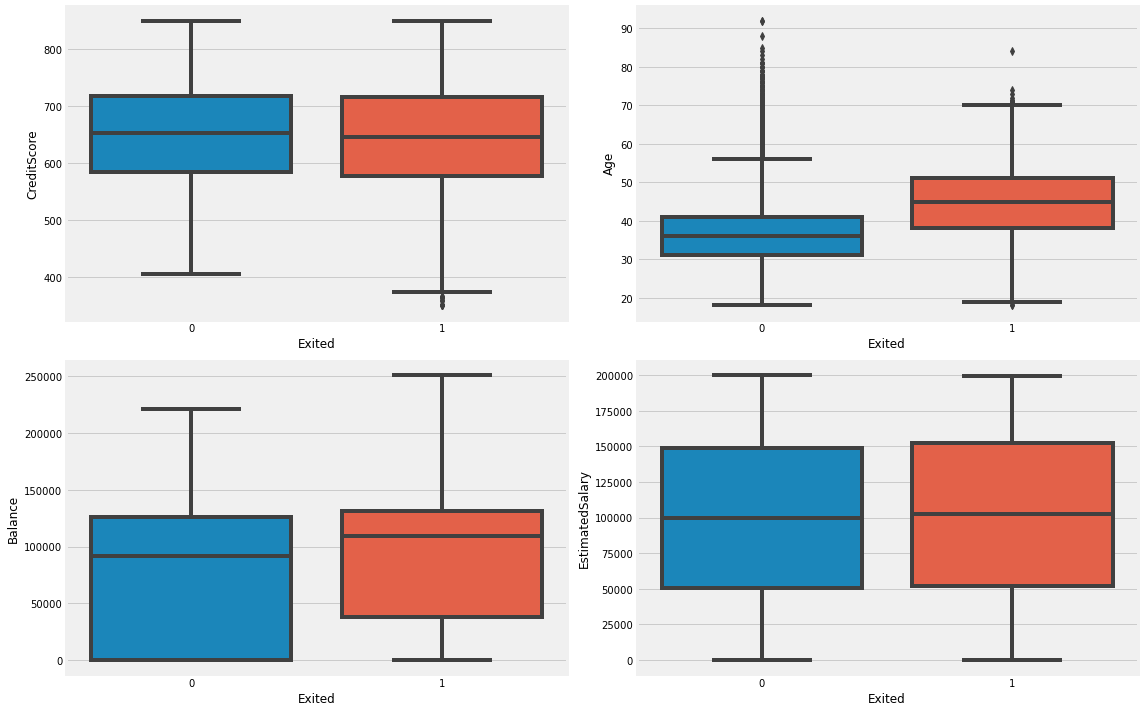

In [10]:
# visualizing continuous variables

fig, ax = plt.subplots(2, 2, figsize = (16, 10))

sns.boxplot(x = 'Exited', y = 'CreditScore', data = df, ax = ax[0][0])
sns.boxplot(x = 'Exited', y = 'Age', data = df, ax = ax[0][1])
sns.boxplot(x = 'Exited', y = 'Balance', data = df, ax = ax[1][0])
sns.boxplot(x = 'Exited', y = 'EstimatedSalary', data = df, ax = ax[1][1])

plt.tight_layout()
plt.show()

From above Plots we can conclude that:-

- There is no significant difference in credit score distribution between custers which are churned or not.
- The older customers are churning more than younger ones.
- Bank is loosing customers with significant bank balance.
- Estimated Salary does not have a significant on the likelihood to churn.
- Interestingly, majority of customers that churned are those with credit cards but this can be a coincidence as majority of customers have credit cards.
- Unsurprisingly the inactive members have a greater churn and the overall proportion of inactive members is also very high.

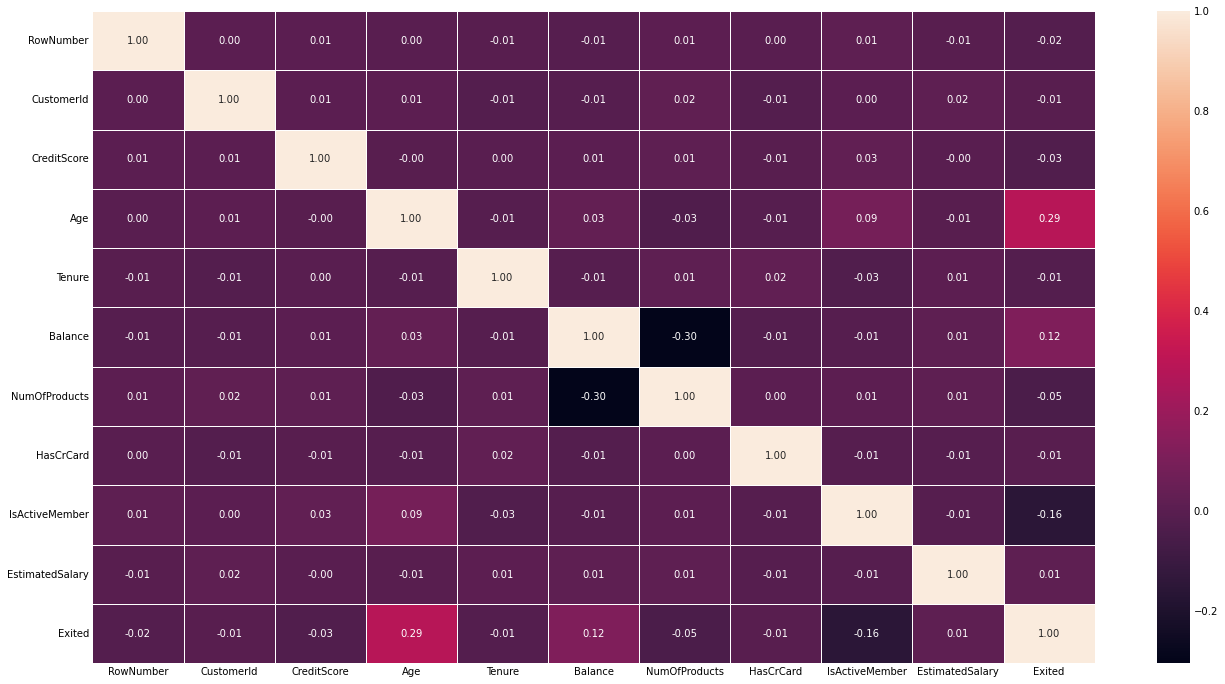

In [11]:
# heatmap 

plt.figure(figsize = (20, 12))

corr = df.corr()

sns.heatmap(corr, linewidths = 1, annot = True, fmt = ".2f")
plt.show()

We can say that there is no multicolinearity present in data.

In [12]:
# dropping columns that are not required.

df.drop(columns = ['RowNumber', 'CustomerId', 'Surname'], axis = 1, inplace = True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [13]:
df.Geography.value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

# Feature Encoding

In [14]:
# Encoding categorical variables

df['Geography'] = df['Geography'].map({'France' : 0, 'Germany' : 1, 'Spain' : 2})
df['Gender'] = df['Gender'].map({'Male' : 0, 'Female' : 1})
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,1,42,2,0.00,1,1,1,101348.88,1
1,608,2,1,41,1,83807.86,1,0,1,112542.58,0
2,502,0,1,42,8,159660.80,3,1,0,113931.57,1
3,699,0,1,39,1,0.00,2,0,0,93826.63,0
4,850,2,1,43,2,125510.82,1,1,1,79084.10,0


# Feature Scaling

In [15]:
#scaling the values


scaler = MinMaxScaler()


df[['CreditScore','Geography', 'Age','Tenure','Balance','NumOfProducts','EstimatedSalary']] = scaler.fit_transform(df[['CreditScore','Geography','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']])

df


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0.538,0.0,1,0.324324,0.2,0.000000,0.000000,1,1,0.506735,1
1,0.516,1.0,1,0.310811,0.1,0.334031,0.000000,0,1,0.562709,0
2,0.304,0.0,1,0.324324,0.8,0.636357,0.666667,1,0,0.569654,1
3,0.698,0.0,1,0.283784,0.1,0.000000,0.333333,0,0,0.469120,0
4,1.000,1.0,1,0.337838,0.2,0.500246,0.000000,1,1,0.395400,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.842,0.0,0,0.283784,0.5,0.000000,0.333333,1,0,0.481341,0
9996,0.332,0.0,0,0.229730,1.0,0.228657,0.000000,1,1,0.508490,0
9997,0.718,0.0,1,0.243243,0.7,0.000000,0.000000,0,1,0.210390,1
9998,0.844,0.5,0,0.324324,0.3,0.299226,0.333333,1,0,0.464429,1


# Feature Selection Using Base Model

In [16]:
target = df['Exited']
features = df.loc[:,df.columns != "Exited"]

In [17]:

features_train, features_test, targets_train, targets_test = train_test_split(features,
                                                                             target,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 

For Feature Selection Lasso Logistic Regression is applied.(L1 regularization).


In [18]:
# Perform GridSearchCV to tune best-fit LR model

param = {'C': [10**-2,10**-1,10**0,10**1,10**2]}

lr_model = LogisticRegression(penalty='l1', solver='liblinear')
gs_model = GridSearchCV(estimator=lr_model, param_grid=param)
gs_model.fit(features_train, targets_train)

# Train a LR model with best parameters
model = LogisticRegression(**gs_model.best_params_, penalty='l1', solver='liblinear')
model.fit(features_train, targets_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [19]:
coef = model.coef_[0]
coef

array([-0.25107757,  0.14477334,  0.47778464,  4.71418698, -0.08421344,
        1.02832454, -0.01551521,  0.        , -1.0045367 ,  0.        ])

In [20]:
imp_features = pd.Series(features_train.columns)[list(coef!=0)]
imp_features[0]

'CreditScore'

Lasso Regression (Logistic Regression with L1-regularization) can be used to remove redundant features from the dataset. L1-regularization introduces sparsity in the dataset and shrinks the values of the coefficients of redundant features to 0.
It is a very useful technique or hacks to reduce the dimensionality of the dataset by removing the irrelevant features.

In [21]:
features_train = features_train[imp_features]
features_train

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,IsActiveMember
9254,0.672,0.0,0,0.189189,0.6,0.000000,0.333333,1
1561,0.564,0.5,0,0.324324,0.4,0.476786,0.333333,1
1670,0.418,1.0,0,0.081081,0.3,0.457317,0.000000,0
6087,0.422,0.0,1,0.121622,0.9,0.540606,0.000000,0
6669,0.334,0.0,0,0.513514,0.9,0.566554,0.000000,0
...,...,...,...,...,...,...,...,...
5734,0.836,0.0,0,0.486486,0.8,0.277853,0.000000,1
5191,0.664,0.0,1,0.540541,0.1,0.000000,0.000000,1
5390,0.770,0.0,1,0.270270,0.1,0.000000,0.666667,0
860,0.634,0.0,0,0.337838,0.8,0.758186,0.000000,0


In [22]:
features_test = features_test[imp_features]
features_test

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,IsActiveMember
6252,0.492,0.5,0,0.189189,0.3,0.385452,0.333333,0
4684,0.546,0.0,0,0.337838,0.1,0.000000,0.333333,1
1731,0.502,1.0,1,0.351351,0.4,0.000000,0.333333,0
4742,0.312,0.5,0,0.554054,0.8,0.474902,0.333333,1
4521,0.420,1.0,1,0.121622,0.7,0.498194,0.000000,1
...,...,...,...,...,...,...,...,...
6412,0.504,0.5,1,0.472973,0.5,0.391668,0.000000,1
8285,0.518,0.0,0,0.094595,1.0,0.000000,0.000000,1
7853,0.760,0.0,1,0.391892,0.7,0.000000,0.000000,0
1095,0.684,0.0,0,0.148649,0.4,0.000000,0.000000,0



# Removing Class Imbalance

- To deal with class imabalance I will be using SMOTE-ENN technique.
- SMOTE + ENN is another hybrid technique where more no. of observations are removed from the sample space. Here, ENN is yet another undersampling technique where the nearest neighbors of each of the majority class is estimated. If the nearest neighbors misclassify that particular instance of the majority class, then that instance gets deleted.
- Integrating this technique with oversampled data done by SMOTE helps in doing extensive data cleaning. Here on misclassification by NN’s samples from both the classes are removed. This results in a more clear and concise class separation.
- It is important to apply SMOTE techniques after splitting the data into train and test data in order to avoid the risk of synthetic samples ending up in the test set.


In [23]:
counter=Counter(targets_train)
print('Before',counter)
smenn=SMOTEENN()
features_train_smenn,targets_train_smenn=smenn.fit_resample(features_train,targets_train)
counter=Counter(targets_train_smenn)
print('After',counter)


Before Counter({0: 6356, 1: 1644})
After Counter({1: 5056, 0: 4145})


In [24]:
# Train a LR model with best parameters
model = LogisticRegression(**gs_model.best_params_, penalty='l1', solver='liblinear')
model.fit(features_train_smenn, targets_train_smenn)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [25]:
#Make the prediction
targets_pred = model.predict(features_test)

In [26]:
print('The accuracy of the base LR Model is: ', model.score(features_test, targets_test))

The accuracy of the base LR Model is:  0.66


Confusion matrix, without normalization
[[1017  590]
 [  90  303]]
Base LR Confusion Matrix
[[0.63285625 0.36714375]
 [0.22900763 0.77099237]]


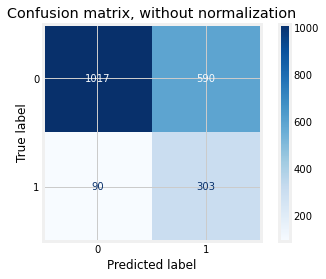

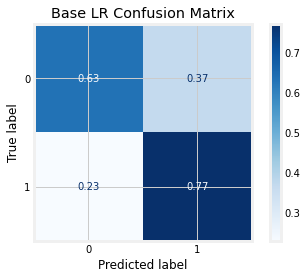

In [27]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Base LR Confusion Matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        features_test,
        targets_test,
        display_labels=targets_test.unique(),
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [28]:
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(targets_test, targets_pred))

Results on the test set:
              precision    recall  f1-score   support

           0       0.92      0.63      0.75      1607
           1       0.34      0.77      0.47       393

    accuracy                           0.66      2000
   macro avg       0.63      0.70      0.61      2000
weighted avg       0.80      0.66      0.69      2000



# MLP BASE MODEL

In [29]:
features_train_smenn.shape


(9201, 8)

In [30]:
targets_train_smenn.shape


(9201,)

In [31]:
#Converting dataframes to numpy arrays 
features_train_smenn=features_train_smenn.values
targets_train_smenn=targets_train_smenn.values
features_test=features_test.values
targets_test=targets_test.values


In [32]:
import torch
from torch import nn
import torch.nn.functional as F
device = 'cpu'

features.shape

In [33]:
# Network Parameters
input_dim = features_train_smenn.shape[1]
hidden_dim = 4
output_dim = len(np.unique(df.Exited))
dropout = 0.5
activation = F.relu

In [34]:
input_dim, hidden_dim, output_dim

(8, 4, 2)

In [35]:
class MLPModule(nn.Module):

    def __init__(self, 
                 input_dim=input_dim, 
                 hidden_dim=hidden_dim,
                 output_dim=output_dim,
                 dropout=dropout,
                 activation = activation):

        super(MLPModule, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.activation = activation
        self.input = nn.Linear(input_dim, hidden_dim,bias=True)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(hidden_dim, hidden_dim,bias=True)
        self.out = nn.Linear(hidden_dim,output_dim,bias=True)



    def forward(self, x):
        x = self.activation(self.input(x))
        x = self.dropout(x)
        x = self.activation(self.hidden(x))
        x = self.dropout(x)
        x = self.activation(self.out(x))
        #x = F.softmax(self.output(x), dim=-1)

        return x




In [36]:
criterion = nn.CrossEntropyLoss

# Callbacks
balanced_accuracy = EpochScoring(scoring='balanced_accuracy', lower_is_better=False)
accuracy = EpochScoring(scoring='accuracy', lower_is_better=False)
early_stopping = EarlyStopping(monitor='valid_loss', patience=10, lower_is_better=True)
checkpoint = Checkpoint(monitor=['train_loss', 'valid_loss'])

In [37]:
features_train_mlp=torch.from_numpy(features_train_smenn).type(torch.FloatTensor)
targets_train_mlp = torch.from_numpy(targets_train_smenn)
features_test_mlp=torch.from_numpy(features_test).type(torch.FloatTensor)
targets_test_mlp = torch.from_numpy(targets_test)

In [38]:
torch.manual_seed(0)

net = NeuralNetClassifier(
    MLPModule,
    max_epochs = 50,
    optimizer = torch.optim.Adam,
    criterion = criterion,
    lr = 0.01,
    iterator_train__shuffle = True, 
    callbacks = [balanced_accuracy, accuracy, early_stopping]
)

net.fit(features_train_mlp,targets_train_mlp);

  epoch    accuracy    balanced_accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  -------------------  ------------  -----------  ------------  ------
      1      0.5497               0.5000        0.6902       0.5497        0.6764  0.1232
      2      0.6105               0.5755        0.6768       0.6105        0.6582  0.1353
      3      0.6882               0.6829        0.6654       0.6882        0.6342  0.1465
      4      0.7132               0.7065        0.6558       0.7132        0.6132  0.1132
      5      0.7165               0.6992        0.6504       0.7165        0.6078  0.1102
      6      0.7338               0.7146        0.6455       0.7338        0.6027  0.1106
      7      0.7648               0.7505        0.6379       0.7648        0.5822  0.1088
      8      0.7833               0.7787        0.6307       0.7833        0.5572  0.1089
      9      0.7659               0.7507        0.6319       0.7659        0.5709  0.1087
     10   

# Hyperparameter Optimisation MLP Model

In [39]:
# redefine the model with undefined hyperparameters for use with GridSearchCV
net = NeuralNetClassifier(
    MLPModule,
    criterion = criterion,
    iterator_train__shuffle = True, 
    callbacks = [early_stopping]
    
)

RANDOM GRID SEARCH

In [40]:

net.set_params(verbose=0)
params = {
    'lr': [0.0001,0.001, 0.01],
    'batch_size':[128,256,512],
    'optimizer':[optim.Adam, optim.SGD],
    'max_epochs': [20,30,40], # figure out the best number of epochs later with early stopping
    'module__hidden_dim': [100,150,200],
    'module__dropout': [0.1, 0.5],
    'module__activation':[F.relu, F.tanh]
}

MLP_rs= RandomizedSearchCV(net, 
                           params, 
                           refit=False, 
                           cv=3, 
                           scoring='accuracy', 
                           verbose=1)

MLP_rs.fit(features_train_mlp, targets_train_mlp)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.MLPModule'>,
),
                   param_distributions={'batch_size': [128, 256, 512],
                                        'lr': [0.0001, 0.001, 0.01],
                                        'max_epochs': [20, 30, 40],
                                        'module__activation': [<function relu at 0x7fcca8b08040>,
                                                               <function tanh at 0x7fcca8b08af0>],
                                        'module__dropout': [0.1, 0.5],
                                        'module__hidden_dim': [100, 150, 200],
                                        'optimizer': [<class 'torch.optim.adam.Adam'>,
                                                      <class 'torch.optim.sgd.SGD'>]},
                   refit=False, scoring='accuracy', verbose=1)

In [41]:
print("")
print("best score: {:.3f}".format(MLP_rs.best_score_))
print("")
print("best params: {}".format(MLP_rs.best_params_))


best score: 0.905

best params: {'optimizer': <class 'torch.optim.adam.Adam'>, 'module__hidden_dim': 100, 'module__dropout': 0.1, 'module__activation': <function relu at 0x7fcca8b08040>, 'max_epochs': 40, 'lr': 0.01, 'batch_size': 512}


# GridSearchCV

In [42]:
net.set_params(verbose=0)
params = {
    'lr': [0.001, 0.01],
    'batch_size':[128,256,300],
    'optimizer':[optim.Adam],
    'max_epochs': [30,40,50], # figure out the best number of epochs later with early stopping
    'module__hidden_dim': [100,200,250],
    'module__dropout': [0.5,1],
    'module__activation':[F.relu, F.tanh]
}

MLP_gs= GridSearchCV(net, 
                     params, 
                     refit=False, 
                     cv=3, 
                     scoring='accuracy', 
                     verbose=1)

MLP_gs.fit(features_train_mlp, targets_train_mlp)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


GridSearchCV(cv=3,
             estimator=<class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.MLPModule'>,
),
             param_grid={'batch_size': [128, 256, 300], 'lr': [0.001, 0.01],
                         'max_epochs': [30, 40, 50],
                         'module__activation': [<function relu at 0x7fcca8b08040>,
                                                <function tanh at 0x7fcca8b08af0>],
                         'module__dropout': [0.5, 1],
                         'module__hidden_dim': [100, 200, 250],
                         'optimizer': [<class 'torch.optim.adam.Adam'>]},
             refit=False, scoring='accuracy', verbose=1)

In [43]:
print('Best parameters found:\n', MLP_gs.best_params_)

Best parameters found:
 {'batch_size': 300, 'lr': 0.01, 'max_epochs': 50, 'module__activation': <function relu at 0x7fcca8b08040>, 'module__dropout': 0.5, 'module__hidden_dim': 250, 'optimizer': <class 'torch.optim.adam.Adam'>}


In [44]:
print("")
print("best score: {:.3f}".format(MLP_gs.best_score_))
print("")
print("best params: {}".format(MLP_gs.best_params_))


best score: 0.897

best params: {'batch_size': 300, 'lr': 0.01, 'max_epochs': 50, 'module__activation': <function relu at 0x7fcca8b08040>, 'module__dropout': 0.5, 'module__hidden_dim': 250, 'optimizer': <class 'torch.optim.adam.Adam'>}


In [45]:
#GRID SEARCH RESULTS & EXPORT
MLP_gs_results = pd.DataFrame.from_dict(MLP_gs.cv_results_)
MLP_gs_results.to_excel("MLP GS Results.xlsx") 

# Final Fit of MLP


from grid search it was determined that these parametered yielded the highest accuracy:

In [46]:
# Network parameters
hidden_dim = 200              
input_size = features_train_smenn.shape[1]   
num_classes = len(np.unique(targets_train_smenn))                
dropout = 0.5
activation = F.relu

# Hyperparameters
batch_size = 300
lr = 0.01
epochs = 50
optimizer = optim.Adam
criterion = nn.CrossEntropyLoss

In [47]:
class MLPModule(nn.Module):

    def __init__(self, 
                 input_dim=input_dim, 
                 hidden_dim=hidden_dim,
                 output_dim=output_dim,
                 dropout=dropout,
                 activation = activation):

        super(MLPModule, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.activation = activation
        self.input = nn.Linear(input_dim, hidden_dim,bias=True)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(hidden_dim, hidden_dim,bias=True)
        self.out = nn.Linear(hidden_dim,output_dim,bias=True)



    def forward(self, x):
        x = self.activation(self.input(x))
        x = self.dropout(x)
        x = self.activation(self.hidden(x))
        x = self.dropout(x)
        x = self.activation(self.out(x))
        #x = F.softmax(self.output(x), dim=-1)

        return x

In [48]:
torch.manual_seed(0)

final_MLP = NeuralNetClassifier(
    MLPModule,
    max_epochs = epochs,
    batch_size = batch_size,
    optimizer = optimizer,
    criterion = criterion,
    lr = lr,
    iterator_train__shuffle = True, 
    callbacks = [balanced_accuracy, accuracy, early_stopping]
)


t = time.time()
final_MLP.fit(features_train_mlp, targets_train_mlp);
elapsed = time.time() - t

  epoch    accuracy    balanced_accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  -------------------  ------------  -----------  ------------  ------
      1      0.7311               0.7361        0.6205       0.7311        0.5629  0.1628
      2      0.7729               0.7822        0.5617       0.7729        0.5342  0.1375
      3      0.7985               0.8043        0.5433       0.7985        0.5097  0.1418
      4      0.8436               0.8399        0.5117       0.8436        0.4698  0.1398
      5      0.8479               0.8424        0.4866       0.8479        0.4557  0.1455
      6      0.8664               0.8640        0.4852       0.8664        0.4500  0.1756
      7      0.8609               0.8553        0.4746       0.8609        0.4553  0.1697
      8      0.8800               0.8804        0.4754       0.8800        0.4474  0.1611
      9      0.8756               0.8791        0.4681       0.8756        0.4468  0.1418
     10   

In [49]:
print("Training time: ", elapsed)

Training time:  7.568130016326904


In [50]:
# Export the final MLP
import pickle
with open('final_mlp.pickle', 'wb') as output:
    pickle.dump(final_MLP, output)

In [51]:
# make predicitons and time it
features_test_mlp=torch.from_numpy(features_test).type(torch.FloatTensor)
targets_test_mlp = torch.from_numpy(targets_test)
t = time.time()
MLP_pred = final_MLP.predict(features_test_mlp)
elapsed = time.time() - t

print("Prediction time: ", elapsed)

Prediction time:  0.024937152862548828


In [52]:
# Training accuracy
mlp_train_ac = accuracy_score(targets_train_mlp, final_MLP.predict(features_train_mlp))

print("The training accuracy is: ", mlp_train_ac)

The training accuracy is:  0.9014237582871427


In [53]:
# Test accuracy
mlp_test_ac = accuracy_score(targets_test_mlp, MLP_pred)
print("The test accuracy is: ", mlp_test_ac)

The test accuracy is:  0.752


In [54]:
# cross validated accuracy
print('The cross validated accuracy is: ', cross_val_score(final_MLP, features_train_mlp, targets_train_mlp, cv=3));

  epoch    accuracy    balanced_accuracy    train_loss    valid_acc    valid_loss     dur
-------  ----------  -------------------  ------------  -----------  ------------  ------
      1      0.7327               0.7322        0.6154       0.7327        0.5327  0.0923
      2      0.7783               0.7800        0.5345       0.7783        0.4587  0.0890
      3      0.8321               0.8306        0.4609       0.8321        0.3834  0.0881
      4      0.8443               0.8341        0.4119       0.8443        0.3475  0.0914
      5      0.8647               0.8588        0.3773       0.8647        0.3193  0.0881
      6      0.8680               0.8607        0.3494       0.8680        0.2964  0.0892
      7      0.8761               0.8754        0.3246       0.8761        0.2829  0.0877
      8      0.8729               0.8710        0.3223       0.8729        0.2718  0.0900
      9      0.8778               0.8754        0.3151       0.8778        0.2667  0.0913
     10   

     22      0.8818               0.8845        0.4594       0.8818        0.4383  0.0878
     23      0.8851               0.8878        0.4527       0.8851        0.4379  0.0900
     24      0.8794               0.8827        0.4565       0.8794        0.4432  0.0941
     25      0.8843               0.8838        0.4525       0.8843        0.4395  0.0918
     26      0.8778               0.8787        0.4552       0.8778        0.4428  0.0892
     27      0.8851               0.8873        0.4523       0.8851        0.4442  0.0907
     28      0.8826               0.8844        0.4524       0.8826        0.4378  0.0920
     29      0.8704               0.8678        0.4546       0.8704        0.4456  0.0889
     30      0.8769               0.8774        0.4540       0.8769        0.4391  0.0882
     31      0.8851               0.8861        0.4491       0.8851        0.4376  0.0879
     32      0.8843               0.8862        0.4521       0.8843        0.4348  0.0885
     33   

In [55]:
# Classification report
print("Classification report")
print(classification_report(targets_test, MLP_pred))

Classification report
              precision    recall  f1-score   support

           0       0.94      0.74      0.83      1607
           1       0.43      0.80      0.56       393

    accuracy                           0.75      2000
   macro avg       0.68      0.77      0.69      2000
weighted avg       0.84      0.75      0.77      2000



Base LR Confusion Matrix
[[0.74113255 0.25886745]
 [0.20356234 0.79643766]]


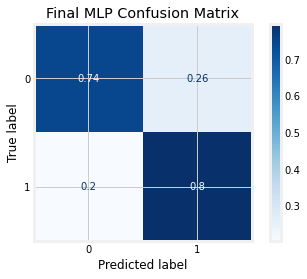

In [56]:
disp = ConfusionMatrixDisplay.from_estimator(
        final_MLP,
        features_test_mlp,
        targets_test_mlp,
        display_labels=np.unique(targets_test),
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
disp.ax_.set_title('Final MLP Confusion Matrix')

print(title)
print(disp.confusion_matrix)

plt.show()

# Support Vector Machines

In [57]:
#Create the SVM model
svc_base = SVC(gamma='auto')

In [58]:
#Fit the model for the data
svc_base.fit(features_train_smenn, targets_train_smenn)

#Make the prediction
y_pred_base = svc_base.predict(features_test)

In [59]:
print('The accuracy of the base SVM is: ', svc_base.score(features_test, targets_test))

The accuracy of the base SVM is:  0.707


Base LR Confusion Matrix
[[0.68512757 0.31487243]
 [0.20356234 0.79643766]]


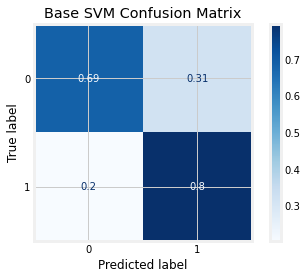

In [60]:
disp = ConfusionMatrixDisplay.from_estimator(
        svc_base,
        features_test,
        targets_test,
        display_labels=np.unique(targets_test),
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
disp.ax_.set_title('Base SVM Confusion Matrix')

print(title)
print(disp.confusion_matrix)

plt.show()

In [61]:
accuracies = cross_val_score(estimator = svc_base, X = features_train_smenn, y = targets_train_smenn, cv = 3);
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))

Accuracy: 81.75 %


Hyperparameter Optimisation for SVM

SVC hyperparameters to be tuned:

- C, Regularization parameter
- kernel, Specifies the kernel type to be used in the algorithm
- degree, Degree of the polynomial kernel function
- gamma, Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.

https://scikit-learn.org/stable/modules/grid_search.html

- First we will use RandomSearchCV since the run time is significantly lower than GridSearchCV. Once there is a general idea of what hyperparameters to use GridSearchCV will be used

In [62]:
# find out the hyperparameters currently in use
svc_base.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [63]:
## DEFINE THE GRID ###########################################

# C
C = np.linspace(1,100, 30)

# gamma
gamma = [0.001,0.01, 0.1, 1]

# degree
degree = [1, 2, 3, 4, 5]

# kernel
kernel = ['linear', 'rbf', 'poly']

# probability
probability = [True, False]

In [64]:
# SVC random grid
random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }



In [65]:
## RANDOM SEARCH ###########################################

# First create the base model to tune
#svc = SVC(random_state=0)
svc = SVC(random_state=0)

# Define the random search
n_iter_search = 30
random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=random_grid,
                                   n_iter=n_iter_search,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=3, 
                                   random_state=0, 
                                   n_jobs=-1,
                                   refit=True)

# Fit the random search model
random_search.fit(features_train_smenn, targets_train_smenn)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3, estimator=SVC(random_state=0), n_iter=30, n_jobs=-1,
                   param_distributions={'C': array([  1.        ,   4.4137931 ,   7.82758621,  11.24137931,
        14.65517241,  18.06896552,  21.48275862,  24.89655172,
        28.31034483,  31.72413793,  35.13793103,  38.55172414,
        41.96551724,  45.37931034,  48.79310345,  52.20689655,
        55.62068966,  59.03448276,  62.44827586,  65.86206897,
        69.27586207,  72.68965517,  76.10344828,  79.51724138,
        82.93103448,  86.34482759,  89.75862069,  93.17241379,
        96.5862069 , 100.        ]),
                                        'degree': [1, 2, 3, 4, 5],
                                        'gamma': [0.001, 0.01, 0.1, 1],
                                        'kernel': ['linear', 'rbf', 'poly'],
                                        'probability': [True, False]},
                   random_state=0, scoring='accuracy', verbose=3)

In [66]:
print("")
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)


The best hyperparameters from Random Search are:
{'probability': True, 'kernel': 'rbf', 'gamma': 1, 'degree': 4, 'C': 76.10344827586206}

The mean accuracy of a model with these hyperparameters is:
0.9233778937072058


In [67]:
## DEFINE THE GRID ########################################


#C = np.linspace(65,85, 10)
#gamma = [0.001,0.01, 0.1]
#degree = [4,5,6,7]
#probability = [True, False]
#kernel = ['rbf']


C = np.linspace(75,79,1)
degree = [3, 4]
gamma = [0.1,1]
probability = [True, False]

#param_grid = {'estimator__C': C,
#              'estimator__kernel': kernel,
#              'estimator__gamma': gamma,
#              'estimator__degree': degree,
#              'estimator__probability': probability
#             }


param_grid = [
  {'C': C, 'kernel':['linear'], 'probability':probability},
  {'C': C, 'kernel':['poly'], 'gamma':gamma,'degree':degree, 'probability':probability},
  {'C': C, 'kernel':['rbf'], 'gamma':gamma, 'probability':probability}
]


## GRID SEARCH ###########################################

# First create the base model to tune
svc = SVC(random_state=0)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .20, random_state = 0)

# Define the grid search
grid_search = GridSearchCV(estimator=svc,
                                   param_grid=param_grid,
                                   scoring='accuracy',
                                   cv=cv_sets, 
                                   verbose=3,  
                                   n_jobs=-1,
                                   refit=True)

# Fit the random search model
grid_search.fit(features_train_smenn, targets_train_smenn)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=0, test_size=0.2, train_size=None),
             estimator=SVC(random_state=0), n_jobs=-1,
             param_grid=[{'C': array([75.]), 'kernel': ['linear'],
                          'probability': [True, False]},
                         {'C': array([75.]), 'degree': [3, 4],
                          'gamma': [0.1, 1], 'kernel': ['poly'],
                          'probability': [True, False]},
                         {'C': array([75.]), 'gamma': [0.1, 1],
                          'kernel': ['rbf'], 'probability': [True, False]}],
             scoring='accuracy', verbose=3)

In [68]:
print("")
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)


The best hyperparameters from Grid Search are:
{'C': 75.0, 'gamma': 1, 'kernel': 'rbf', 'probability': True}

The mean accuracy of a model with these hyperparameters is:
0.9284808980626472


In [69]:
final_svc = grid_search.best_estimator_
final_svc

SVC(C=75.0, gamma=1, probability=True, random_state=0)

In [70]:
SVM_gs_results = pd.DataFrame.from_dict(grid_search.cv_results_)
SVM_gs_results.to_excel("SVM GS Results.xlsx")  

# Final Fit for SVM model

In [71]:

final_svc = SVC(C=75,kernel='rbf', gamma=1,probability=True, random_state=0)

In [72]:
# fit the final SVM Model and find training time


t = time.time()
final_svc.fit(features_train_smenn, targets_train_smenn)
elapsed = time.time() - t

print("Training time: ", elapsed)

Training time:  9.515570878982544


In [73]:
# Training accuracy
svm_train_ac = accuracy_score(targets_train_smenn, final_svc.predict(features_train_smenn))
print("The training accuracy is: ", svm_train_ac)

The training accuracy is:  0.943701771546571


In [74]:
#Test Accuracy

# Make predictions and time the process
t = time.time()
final_svc_pred = final_svc.predict(features_test)
elapsed = time.time() - t

print("Prediction time: ", elapsed)

Prediction time:  0.3674046993255615


In [75]:
# Test accuracy
svm_test_ac =  accuracy_score(targets_test, final_svc_pred)
print("The test accuracy is: ", svm_test_ac)

The test accuracy is:  0.74


In [76]:
# cross validated accuracy
print('The cross validated accuracy is: ', cross_val_score(final_svc, features_train_smenn, targets_train_smenn, cv=3))

The cross validated accuracy is:  [0.92305184 0.9246821  0.92207369]


In [77]:
# Classification report
print("Classification report")
print(classification_report(targets_test,final_svc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.93      0.73      0.82      1607
           1       0.41      0.77      0.54       393

    accuracy                           0.74      2000
   macro avg       0.67      0.75      0.68      2000
weighted avg       0.83      0.74      0.76      2000



Base LR Confusion Matrix
[[0.73304294 0.26695706]
 [0.23155216 0.76844784]]


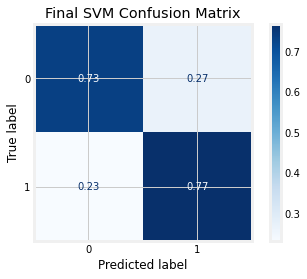

In [78]:
disp = ConfusionMatrixDisplay.from_estimator(
        final_svc,
        features_test,
        targets_test,
        display_labels=np.unique(targets_test),
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
disp.ax_.set_title('Final SVM Confusion Matrix')

print(title)
print(disp.confusion_matrix)

plt.show()

In [79]:
accuracy_score(targets_test, svc_base.predict(features_test))

0.707

In [80]:
accuracy_score(targets_test, final_svc.predict(features_test))

0.74

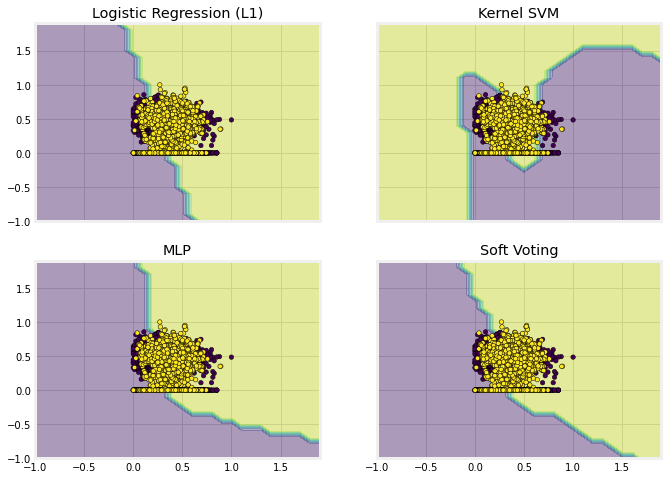

In [81]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt


from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

X=features_train_smenn[:,[3,5]]
y=targets_train_smenn

# Training classifiers
clf1 = LogisticRegression(C=0.1, penalty='l1', solver='liblinear')
clf2 = SVC(C=75, gamma=1,kernel='rbf',probability=True, random_state=0)
clf3 = MLPClassifier(hidden_layer_sizes=250,activation='relu',solver='adam', alpha=0.0001, batch_size=128, 
                     learning_rate='constant', learning_rate_init=0.001, shuffle=True,early_stopping=True)

eclf = VotingClassifier(
    estimators=[("lr", clf1), ("svc", clf2),("mlp", clf3)],
    voting="soft",
)

clf1.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)
eclf.fit(X, y)



# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex="col", sharey="row", figsize=(10, 8))

for idx, clf, tt in zip(
    product([0, 1], [0, 1]),
    [clf1, clf2, clf3, eclf],
    ["Logistic Regression (L1)", "Kernel SVM","MLP", "Soft Voting"],
):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor="k")
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()

A Voting Classifier is a machine learning model that trains on an ensemble of numerous models and predicts an output (class) based on their highest probability of chosen class as the output.
It simply aggregates the findings of each classifier passed into Voting Classifier and predicts the output class based on the highest majority of voting. The idea is instead of creating separate dedicated models and finding the accuracy for each them, we create a single model which trains by these models and predicts output based on their combined majority of voting for each output class.


# ROC Curves

In [82]:


def plot_roc_curve(y_test, y_pred, model):
    
    n_classes = 2

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(0,2):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(0,2)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(0,2):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = itertools.cycle(['aqua', 'coral', 'gold', 'ivory', 'green', 'blue', 'cyan'])
    colors = matplotlib.cm.get_cmap('tab10')
    colors = colors(np.linspace(0, 1, 2))
    for i, color in zip(range(0,2), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                       ''.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} Receiver Operating Curve'.format(model), fontsize= 16)
    plt.legend(loc="lower right")
    plt.show()

AUC: 0.836


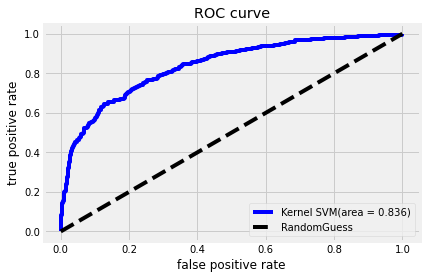

In [83]:
decision_scores = final_svc.decision_function(features_test)
fpr, tpr, thres = roc_curve(targets_test, decision_scores)
print('AUC: {:.3f}'.format(roc_auc_score(targets_test, decision_scores)))
from sklearn.metrics import auc
auc_svm = auc(fpr, tpr)
# roc curve
plt.plot(fpr, tpr, "b", label='Kernel SVM(area = {:.3f})'.format(auc_svm))
plt.plot([0,1],[0,1], "k--", label='RandomGuess')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()

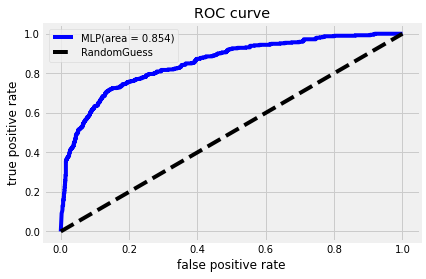

In [84]:


fpr, tpr, thresholds = roc_curve(targets_test, final_MLP.predict_proba(features_test_mlp)[:,1])

from sklearn.metrics import auc
auc_mlp = auc(fpr, tpr)

# roc curve
plt.plot(fpr, tpr, "b", label='MLP(area = {:.3f})'.format(auc_mlp))

plt.plot([0,1],[0,1], "k--", label='RandomGuess')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()

In [85]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set_style("whitegrid")
#sns.set_palette("hls")
sns.set_context("notebook")

def plot_roc_curve(y_test, y_pred, model):
    
    n_classes = 2

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(0,2):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test, y_pred[:,1])
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(0,2)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(0,2):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = itertools.cycle(['aqua', 'coral', 'gold', 'ivory', 'green', 'blue', 'cyan'])
    colors = matplotlib.cm.get_cmap('tab10')
    colors = colors(np.linspace(0, 1, 2))
    for i, color in zip(range(0,2), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {0:0.2f})'
                       ''.format(roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} Receiver Operating Curve'.format(model), fontsize= 16)
    plt.legend(loc="lower right")
    plt.show()

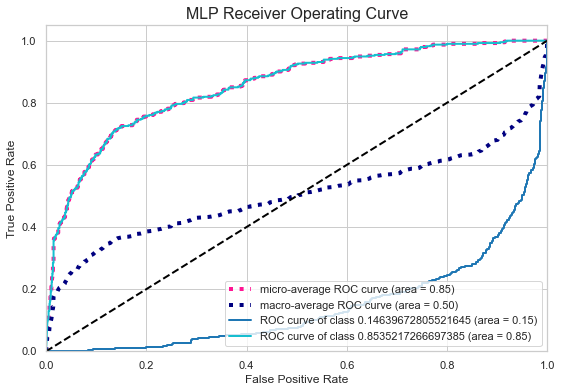

In [86]:
MLP_pred_proba = final_MLP.predict_proba(features_test_mlp)
plot_roc_curve(targets_test, MLP_pred_proba, 'MLP')

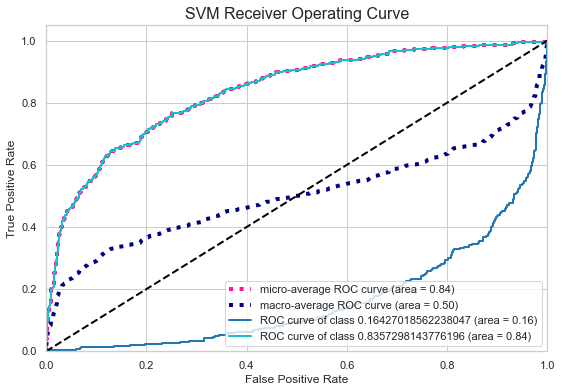

In [87]:
SVM_pred_proba = final_svc.predict_proba(features_test)
plot_roc_curve(targets_test, SVM_pred_proba, 'SVM')

# Test Script

In [88]:
# Export the test features

with open('features_test.pickle', 'wb') as output:
    pickle.dump(features_test, output)

In [89]:
# Export the test targets

with open('targets_test.pickle', 'wb') as output:
    pickle.dump(targets_test, output)

In [90]:
# Export the final SVM

with open('final_svc.pickle', 'wb') as output:
    pickle.dump(final_svc, output)

In [91]:
# Export the final MLP

with open('final_mlp.pickle', 'wb') as output:
    pickle.dump(final_MLP, output)

In [92]:
# Load the test features

with open('features_test.pickle', 'rb') as output:
    features_test_loaded=pickle.load(output)

In [93]:
# Load the test targets

with open('targets_test.pickle', 'rb') as output:
    targets_test_loaded=pickle.load(output)

In [94]:
# Load the final MLP

with open('final_mlp.pickle', 'rb') as output:
    final_mlp_loaded=pickle.load(output)

In [95]:
# Load the final SVM

with open('final_svc.pickle', 'rb') as output:
     final_svc_loaded=pickle.load(output)

In [96]:
#Test Accuracy for MLP


# make predicitons and time it
features_test_mlp_loaded=torch.from_numpy(features_test_loaded).type(torch.FloatTensor)
targets_test_mlp_loaded = torch.from_numpy(targets_test_loaded)
t = time.time()
MLP_pred_loaded = final_mlp_loaded.predict(features_test_mlp_loaded)
elapsed = time.time() - t
print("Prediction time: ", elapsed)

# Test accuracy
mlp_test_ac_loaded = accuracy_score(targets_test_mlp_loaded, MLP_pred_loaded)
print("The test accuracy is: ", mlp_test_ac_loaded)

# Classification report
print("Classification report")
print(classification_report(targets_test_mlp_loaded,MLP_pred_loaded))

Prediction time:  0.02380990982055664
The test accuracy is:  0.752
Classification report
              precision    recall  f1-score   support

           0       0.94      0.74      0.83      1607
           1       0.43      0.80      0.56       393

    accuracy                           0.75      2000
   macro avg       0.68      0.77      0.69      2000
weighted avg       0.84      0.75      0.77      2000



In [97]:
#Test Accuracy for SVM

# Make predictions and time the process
t = time.time()
final_svc_loaded_pred = final_svc_loaded.predict(features_test_loaded)
elapsed = time.time() - t

print("Prediction time: ", elapsed)
svm_test_ac_loaded =  accuracy_score(targets_test_loaded, final_svc_loaded_pred)
print("The test accuracy is: ", svm_test_ac_loaded)
# Classification report
print("Classification report")
print(classification_report(targets_test_loaded,final_svc_loaded_pred))

Prediction time:  0.33646178245544434
The test accuracy is:  0.74
Classification report
              precision    recall  f1-score   support

           0       0.93      0.73      0.82      1607
           1       0.41      0.77      0.54       393

    accuracy                           0.74      2000
   macro avg       0.67      0.75      0.68      2000
weighted avg       0.83      0.74      0.76      2000

[CV 1/3] END C=45.37931034482759, degree=4, gamma=1, kernel=rbf, probability=False;, score=0.921 total time=   2.0s
[CV 3/3] END C=45.37931034482759, degree=4, gamma=1, kernel=rbf, probability=False;, score=0.917 total time=   1.9s
[CV 2/3] END C=21.482758620689655, degree=5, gamma=1, kernel=linear, probability=False;, score=0.794 total time=   2.2s
[CV 1/3] END C=21.482758620689655, degree=2, gamma=1, kernel=linear, probability=False;, score=0.784 total time=   2.3s
[CV 3/3] END C=21.482758620689655, degree=2, gamma=1, kernel=linear, probability=False;, score=0.783 total time= 

[CV 1/3] END C=76.10344827586206, degree=4, gamma=1, kernel=rbf, probability=True;, score=0.923 total time=   8.6s
[CV 2/3] END C=48.79310344827586, degree=3, gamma=0.001, kernel=rbf, probability=False;, score=0.794 total time=   3.8s
[CV 1/3] END C=28.310344827586206, degree=4, gamma=0.001, kernel=linear, probability=False;, score=0.784 total time=   2.7s
[CV 3/3] END C=28.310344827586206, degree=4, gamma=0.001, kernel=linear, probability=False;, score=0.783 total time=   3.1s
[CV 1/3] END C=48.79310344827586, degree=5, gamma=0.001, kernel=rbf, probability=True;, score=0.775 total time=  17.4s
[CV 2/3] END C=100.0, degree=3, gamma=0.1, kernel=poly, probability=True;, score=0.855 total time=   7.9s
[CV 1/3] END C=96.58620689655172, degree=5, gamma=0.1, kernel=linear, probability=True;, score=0.785 total time=  18.1s
[CV 3/3] END C=100.0, degree=4, gamma=0.01, kernel=linear, probability=True;, score=0.783 total time=  19.0s
[CV 1/3] END C=82.93103448275862, degree=1, gamma=0.1, kernel=p